# Artigo 6 
Aluno: Samuel Nogueira Bacelar
</br>
Matrícula: 180130722
</br>
GitHub: [SamuelNoB](https://github.com/SamuelNoB)


Este artigo tem como intuito Criar um modelo de classificação de carros usando *Random Forests*. Para esta tarefa será usado o dataset Car Evaluation, disponibilizado pelo framework fastAI, o dataset e as informações dele podem ser encontradas [aqui](https://www.kaggle.com/datasets/elikplim/car-evaluation-data-set)

Instalando algumas bibliotecas necessárias para notebook

In [1]:
# !pip install  fastai matplotlib sklearn -q

ERROR: Could not find a version that satisfies the requirement sklearn (from versions: none)
ERROR: No matching distribution found for sklearn
^C


In [2]:
# ! pip install graphviz

^C


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import re
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import fastai
import matplotlib.pyplot as plt
from numpy import random
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-evaluation-data-set/car_evaluation.csv


# Sobre o Dataset
Car Evaluation Database was derived from a simple hierarchical decision model originally developed for the demonstration of DEX, M. Bohanec, V. Rajkovic: Expert system for decision making. Sistemica 1(1), pp. 145-157, 1990.). The model evaluates cars according to the following concept structure:

```
CAR                      car acceptability
. PRICE                  overall price
. . buying               buying price
. . maint                price of the maintenance
. TECH                   technical characteristics
. . COMFORT              comfort
. . . doors              number of doors
. . . persons            capacity in terms of persons to carry
. . . lug_boot           the size of luggage boot
. . safety               estimated safety of the car
```
Input attributes are printed in lowercase. Besides the target concept (CAR), the model includes three intermediate concepts: PRICE, TECH, COMFORT. Every concept is in the original model related to its lower level descendants by a set of examples (for these examples sets see http://www-ai.ijs.si/BlazZupan/car.html).

The Car Evaluation Database contains examples with the structural information removed, i.e., directly relates CAR to the six input attributes: buying, maint, doors, persons, lug_boot, safety.


Abaixo temos uma descrição dos dados presentes em cada coluna.
```
Class Values:

unacc, acc, good, vgood

Attributes:

buying:   vhigh, high, med, low.
maint:    vhigh, high, med, low.
doors:    2, 3, 4, 5more.
persons:  2, 4, more.
lug_boot: small, med, big.
safety:   low, med, high.
```

Como é possível ver, temos muitos dados categóricos e por isso teremos de transforma-los em dados numericos de modo que o modelo possa processar essas variáveis.

In [4]:
df = pd.read_csv("/kaggle/input/car-evaluation-data-set/car_evaluation.csv")
df

,vhigh,vhigh.1,2,2.1,small,low,unacc
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc
...,...,...,...,...,...,...,...
1722,low,low,5more,more,med,med,good
1723,low,low,5more,more,med,high,vgood
1724,low,low,5more,more,big,low,unacc
1725,low,low,5more,more,big,med,good


Os nomes das colunas não estão condizentes com o que é mostrado na descrição do dataset e por isso vamos renomea-las da seguinte forma.

```
vhigh   --> buying
vhigh.1 --> maint
2       --> doors
2.1     --> persons
small   --> lug_boot
low     --> safety
unacc    --> decision
```

In [5]:
new_columns = {
    "vhigh": "buying",
    "vhigh.1": "maint",
    "2": "doors", 
    "2.1": "persons",
    "small": "lug_boot",
    "low": "safety",
    "unacc": "decision"
}
df = df.rename(columns=new_columns)
df

,buying,maint,doors,persons,lug_boot,safety,decision
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc
...,...,...,...,...,...,...,...
1722,low,low,5more,more,med,med,good
1723,low,low,5more,more,med,high,vgood
1724,low,low,5more,more,big,low,unacc
1725,low,low,5more,more,big,med,good


# Separando dados

Como dito anteriormente os dados deste dataframe são valores categóricos não numéricos, por isso iremos converte-los em valores numéricos e também realizar a separação dos dados na etapa de separação de dados

In [6]:
cats = df.columns.tolist()
cats

['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'decision']

In [7]:
for col in cats:
        df[col] = pd.Categorical(df[col])
df

,buying,maint,doors,persons,lug_boot,safety,decision
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc
...,...,...,...,...,...,...,...
1722,low,low,5more,more,med,med,good
1723,low,low,5more,more,med,high,vgood
1724,low,low,5more,more,big,low,unacc
1725,low,low,5more,more,big,med,good


In [8]:
df_lbl = df.copy()
df_lbl[cats] = df_lbl[cats].apply(lambda x: x.cat.codes)
df_lbl

,buying,maint,doors,persons,lug_boot,safety,decision
0,3,3,0,0,2,2,2
1,3,3,0,0,2,0,2
2,3,3,0,0,1,1,2
3,3,3,0,0,1,2,2
4,3,3,0,0,1,0,2
...,...,...,...,...,...,...,...
1722,1,1,3,2,1,2,1
1723,1,1,3,2,1,0,3
1724,1,1,3,2,0,1,2
1725,1,1,3,2,0,2,1


In [9]:
X=df_lbl.drop('decision',axis=1)
Y=df_lbl['decision']

x_train,x_test,y_train,y_test=train_test_split(X,Y,random_state=42,train_size=0.7)

# Árvore de Decisão

Criaremos uma Árvore de decisão com uma profundidade máxima de 5. Embora essa profundidade não resulte na maior acurácia possível ela foi escolhida pois acabaria gerando uma quantidade enorme de nós para ser visível de forma satisfatória na imagem.

In [10]:
clf = DecisionTreeClassifier(criterion='gini',
                              max_depth=5,
                              random_state=42)

In [11]:
clf.fit(x_train, y_train)


DecisionTreeClassifier(max_depth=5, random_state=42)

Realizando a predição obtemos a acurácia abaixo. Se não limitassemos a profundidade máxima da árvore de decisão teriamos uma acurácia muito maior.

In [12]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error

y_pred = clf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'DecisionTreeClassifier accuracy score: {(accuracy*100).round(2)}%')
error = mean_absolute_error(y_test, clf.predict(x_test))
print(f'DecisionTreeClassifier error rate: {(error*100).round(2)}%')

DecisionTreeClassifier accuracy score: 87.67%
DecisionTreeClassifier error rate: 26.01%


Após o treinamento podemos visualizar como a árvore de decisão formada

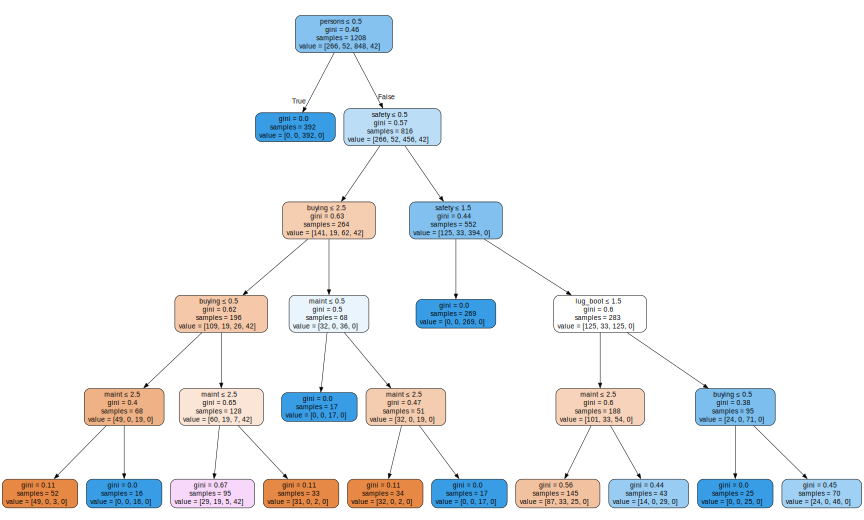

In [13]:

import graphviz
from sklearn.tree import export_graphviz

def draw_tree(t, df, size=12, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

draw_tree(clf, x_train)

## Matriz de confusão

Text(50.722222222222214, 0.5, 'Actual')

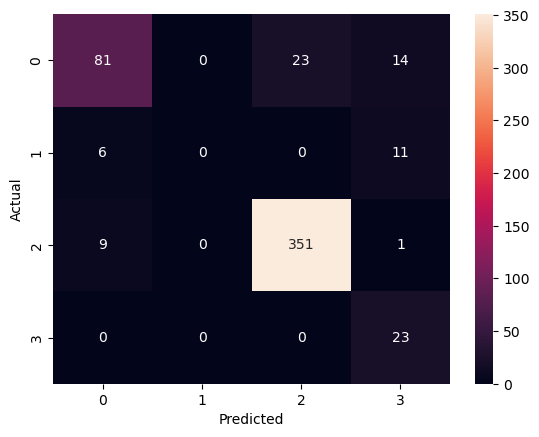

In [14]:

sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")

## Obtendo a importância das colunas

Com nosso modelo treinado podemos medir a importância das colunas. Nota-se no gráfico de barras que o atributo `doors` teve uma importância praticamente nula para as tomadas de decisão da árvore.

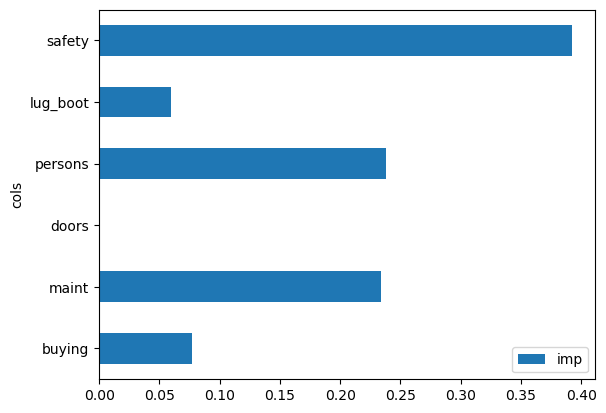

In [15]:
pd.DataFrame(dict(cols=x_train.columns, imp=clf.feature_importances_)).plot('cols', 'imp', 'barh');

# Random Forest Classifier

In [16]:
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(x_train, y_train);

Com um modelo baseado em Random Forest podemos notar que ele é mais certeiro com relação a uma árvore de decisão.

In [17]:
y_pred = rf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'RandomForestClassifier accuracy score: {(accuracy*100).round(2)}%')
error = mean_absolute_error(y_test, rf.predict(x_test))
print(f'RandomForestClassifier error rate: {(error*100).round(2)}%')

RandomForestClassifier accuracy score: 93.06%
RandomForestClassifier error rate: 12.14%


In [26]:
x_test

,buying,maint,doors,persons,lug_boot,safety
599,0,0,2,0,0,1
932,2,3,2,1,0,1
628,0,0,3,0,0,0
1497,1,0,3,1,1,2
1262,2,1,2,2,1,1
...,...,...,...,...,...,...
490,0,3,2,0,1,0
1276,2,1,3,0,0,0
287,3,2,2,2,2,1
701,0,2,2,0,2,1


## Matriz de confusão

Text(50.722222222222214, 0.5, 'Actual')

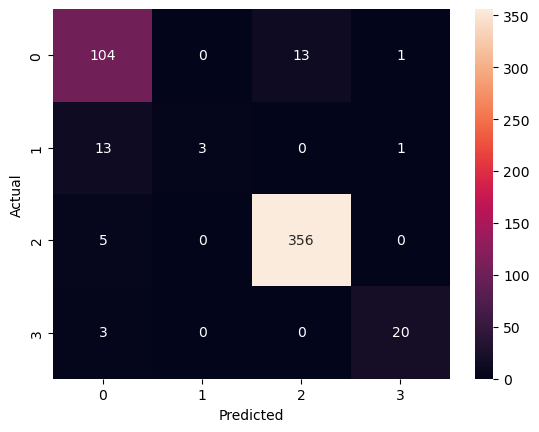

In [18]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")

Testando com a seleção de importância de colunas:


In [19]:
feat_imp_dict = dict(zip(list(x_train.columns), list(clf.feature_importances_)))
sorted_feat_imp_dict = sorted(feat_imp_dict.items(), key=lambda x:x[1])
feat_imp = pd.DataFrame(feat_imp_dict.items(), columns=['column','values']).sort_values(by='values')
feat_imp = feat_imp.iloc[-5:]
feat_imp_cols = feat_imp.transpose().iloc[0].values
feat_imp_cols

array(['lug_boot', 'buying', 'maint', 'persons', 'safety'], dtype=object)

In [27]:
feat_imp_cols

array(['lug_boot', 'buying', 'maint', 'persons', 'safety'], dtype=object)

In [20]:

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(x_train[feat_imp_cols], y_train);

Uma vez que a coluna `doors` era a menos importante e após ser removida e rodar novamente as predições obtemos um leve aumento na assertividade do nosso modelo.

In [21]:
y_pred = rf.predict(x_test[feat_imp_cols])
accuracy = accuracy_score(y_test, y_pred)
print(f'RandomForestClassifier accuracy score: {(accuracy*100).round(2)}%')
error = mean_absolute_error(y_test, rf.predict(x_test[feat_imp_cols]))
print(f'RandomForestClassifier error rate: {(error*100).round(2)}%')

RandomForestClassifier accuracy score: 93.64%
RandomForestClassifier error rate: 12.72%


## Matriz de confusão

Text(50.722222222222214, 0.5, 'Actual')

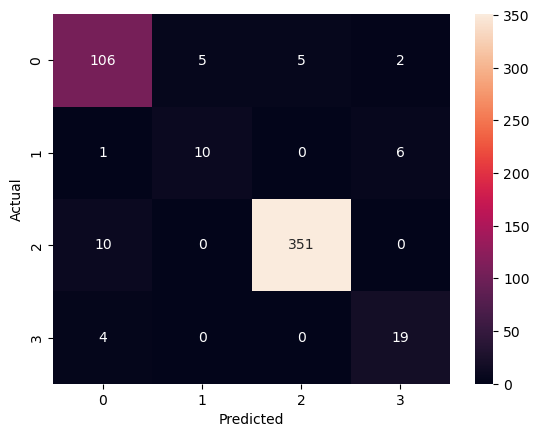

In [22]:

sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Exportando o modelo e Deploy

In [25]:
import pickle

# Carregar o modelo treinado
with open("/kaggle/working/model2.pkl", "wb") as f:
    pickle.dump(rf, f)

## Deploy

É possível interagir com o deploy deste modelo [aqui](http://https://huggingface.co/spaces/SamuelNog/car_classifier)